<a href="https://colab.research.google.com/github/james-t-little/cnn_diss_repo/blob/main/tf_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import os
import random
import PIL
from google.colab import drive
from PIL import Image, ImageOps
from tqdm import tqdm
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [20]:
drive.mount('/content/drive')

path = '/content/drive/MyDrive/dissertation_seg_data'

input_path = os.path.join(path,"input_resize_patches/")

mask_path = os.path.join(path,"mask_resize_patches/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Image size that we are going to use
IMG_SIZE = 512
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 150 classes + `not labeled`
N_CLASSES = 3

In [22]:
def parse_image(image_path: str) -> dict:
    mask_path = tf.strings.regex_replace(image_path, "image", "labels")
    mask_path = tf.strings.regex_replace(mask_path, "input_resize_patches", "mask_resize_patches")

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 1)

    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)

    return {'image' : image, 'segmentation_mask': mask}

In [23]:
train_dataset = tf.data.Dataset.list_files(input_path + "*.png")

train_size = 0.8 * train_dataset.cardinality().numpy()


validation_size = 0.1 * train_dataset.cardinality().numpy()

train_ds = train_dataset.take(train_size)

extra = train_dataset.skip(train_size)  

val_ds = extra.take(validation_size)

test_ds = extra.skip(validation_size)

#for filename in train_dataset.take(10):
  #print(filename.numpy().decode('utf-8'))

train_dataset = train_dataset.map(parse_image)

train_ds = train_ds.map(parse_image)

test_ds = test_ds.map(parse_image)

val_ds = val_ds.map(parse_image)

#for image in train_dataset.take(10):
    #print(image['image'], image['segmentation_mask'],)

In [24]:
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    return input_image, input_mask

def load_image_train(datapoint: dict) -> tuple:
    
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:

    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [25]:
BATCH_SIZE = 8

# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 1000

dataset = {"train": train_ds, "test": test_ds, "val": val_ds}

dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=47)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].repeat()
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size=AUTOTUNE)

In [26]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

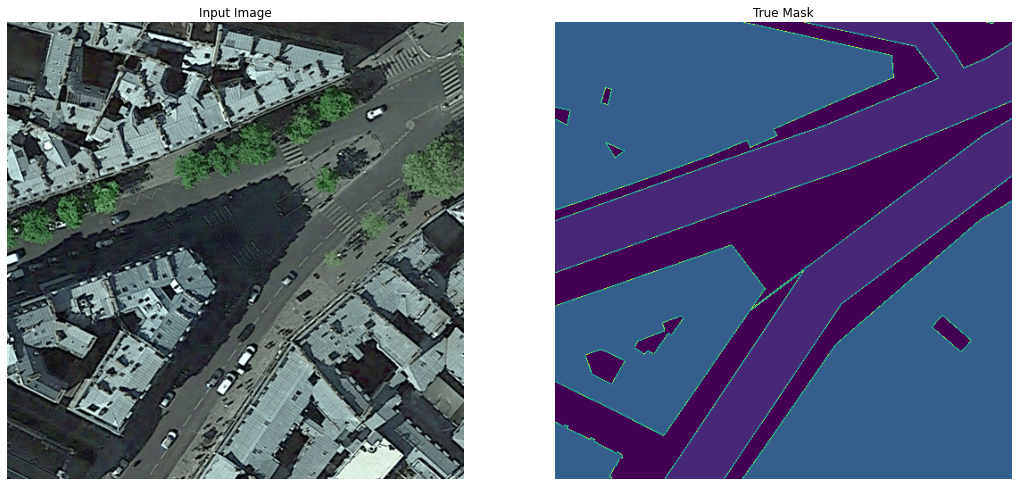

In [11]:
for image,mask in dataset['train'].take(1):
    display_sample([image[0],mask[0]])

In [27]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras.layers import Conv2D, MaxPool2D, Input, concatenate, Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras import regularizers, optimizers
import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, InceptionV3
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [28]:
def unet(img_shape):
    inputs = Input(shape=img_shape)

    previous_block_activation = inputs

    contraction = {}
    for f in [32, 64, 128, 256]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    for f in reversed([32, 64, 128, 256]):
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(255, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

model = unet((IMG_SIZE, IMG_SIZE, N_CHANNELS))

In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [30]:
EPOCHS = 5

from glob import glob

length_data = train_ds.cardinality().numpy()

length_val = val_ds.cardinality().numpy()

STEPS_PER_EPOCH = length_data // BATCH_SIZE
VALIDATION_STEPS = length_val // BATCH_SIZE

length_val

938

In [31]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'])

Epoch 1/5
1172/1172 [==============================] - 763s 585ms/step - loss: 1.4034 - accuracy: 0.5541 - val_loss: 1.1226 - val_accuracy: 0.6395
Epoch 2/5
1172/1172 [==============================] - 674s 575ms/step - loss: 0.9079 - accuracy: 0.6936 - val_loss: 0.8418 - val_accuracy: 0.7198
Epoch 3/5
1172/1172 [==============================] - 674s 575ms/step - loss: 0.7937 - accuracy: 0.7420 - val_loss: 0.7899 - val_accuracy: 0.7422
Epoch 4/5
1172/1172 [==============================] - 674s 575ms/step - loss: 0.7470 - accuracy: 0.7613 - val_loss: 0.7348 - val_accuracy: 0.7622
Epoch 5/5
1172/1172 [==============================] - 674s 575ms/step - loss: 0.7175 - accuracy: 0.7733 - val_loss: 0.7200 - val_accuracy: 0.7680


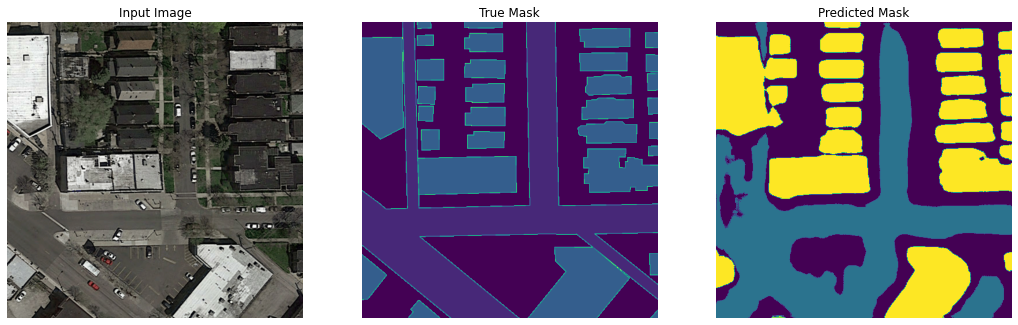

In [32]:
def display_sample(display_list):
    
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

for image, mask in dataset['test'].take(1):
        pred_mask = model.predict(image)
        display_sample([image[0], mask[0], create_mask(pred_mask[0])])